In [1]:
from copy import deepcopy
import tqdm
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
import torch

from dynamical_systems import LDS, COCO, LinearRegression, MNIST
from controllers import LQR, GPC, BPC, RBPC, LiftedBPC
from lifters import NoLift, RandomLift, LearnedLift
from sysid import SysID
from rescalers import IDENTITY, FIXED_RESCALE, EMA_RESCALE, ADAM, D_ADAM, DoWG

In [2]:
from controllers import Controller
from dynamical_systems import DynamicalSystem
from stats import Stats

def run_trial(controller: Controller, 
              system: DynamicalSystem, 
              T: int, 
              reset_every: int = None,
              reset_seed: int = None,
              wordy: bool = True):
    
    # initial control
    control = controller.initial_control if hasattr(controller, 'initial_control') else jnp.zeros(du)  
    
    # run trial
    pbar = tqdm.trange(T) if wordy else range(T)
    for t in pbar:
        if reset_every is not None and t % reset_every == 0:
            print('reset!')
            system.reset(reset_seed)
            
        cost, state = system.interact(control)  # state will be `None` for unobservable systems
        control = controller.get_control(cost, state)
        
        if (state is not None and jnp.isnan(state)) or (cost > 1e20):
            print('WARNING: state {} or cost {} diverged'.format(state, cost))
            return None, None
    
    return deepcopy(system.stats), deepcopy(controller.stats)

# LDS

In [ ]:
def plot_lds_stats(all_system_stats, all_controller_stats={}):
    plt.clf()
    n = 4
    nrows = n + (len(all_controller_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    for method, ss in all_system_stats.items():
        ss.plot(ax[0, 0], 'xs', label=method)
#         ss.plot(ax[0, 1], 'ws', label=method)
        ss.plot(ax[1, 0], 'us', label=method)
        ss.plot(ax[1, 1], 'fs', label=method)
    
    for i, (method, cs) in enumerate(all_controller_stats.items()):
        cs.plot(ax[2, 0], '||A||_op', label=method)
        cs.plot(ax[2, 1], '||B||_F', label=method)
        cs.plot(ax[3, 0], '||A-BK||_op', label=method)
        cs.plot(ax[3, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        cs.plot(ax[0, 1], 'disturbances', label=method)
        cs.plot(i_ax, 'K @ state', label='K @ state')
        cs.plot(i_ax, 'M \cdot w', label='M \cdot w')
        cs.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    ax[0, 0].set_title('position'); ax[0, 0].legend()
    ax[0, 1].set_title('disturbances'); ax[0, 1].legend()
    ax[1, 0].set_title('controls'); ax[1, 0].legend()
    ax[1, 1].set_title('costs'); ax[1, 1].legend()
    
    ax[2, 0].set_title('||A||_op'); ax[2, 0].legend()
    ax[2, 1].set_title('||B||_F'); ax[2, 1].legend()
    
    ax[3, 0].set_title('||A-BK||_op'); ax[3, 0].legend()
    ax[3, 1].set_title('lifter losses'); ax[3, 1].legend()
    pass

In [ ]:
SEED = None
du = 1  # control dim
ds = 1  # state dim
h = 5  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 10  # dimension to lift to
T = 1300
T0 = 400
disturbance_type = 'sinusoidal'
cost_fn = 'quad'
M_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
M0_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
K_UPDATE_RESCALER = lambda : ADAM(0.00, betas=(0.9, 0.999))

sysid_method = 'regression'
sysid_scale = 0.4

learned_lift_args = {
    'lift_lr': 0.01,
    'sysid_lr': 0.01,
    'cost_lr': 0.01,
    'depth': 12,
    'buffer_maxlen': 200,
    'batch_size': 20,
    'seed': SEED
}

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (M_UPDATE_RESCALER, M0_UPDATE_RESCALER, K_UPDATE_RESCALER),
    'T0': T0,
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_sigmoid': True,
    'K_every': 100000,
    'seed': SEED
}

# get system
lds = LDS(ds, du, disturbance_type, cost_fn, seed=SEED)

# get controllers
ll = LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args)
controllers = {
    'LQR': LQR(lds.A, lds.B, jnp.eye(ds), lds.R),
    'GPC': GPC(lds.A, lds.B, Q=jnp.eye(ds), R=lds.R, H=h, lr_scale=0.01, decay=False),
#     'BPC': BPC(lds.A, lds.B, Q=jnp.eye(ds), R=lds.R, H=h, lr_scale=0.005, delta=0.01),
#     'RBPC': RBPC(lds.A, lds.B, Q=jnp.eye(ds), R=lds.R, H=h, M=h, lr=0.01, delta=0.01, noise_sd=0.05),
    
#     'No Lift': LiftedBPC(lifter=NoLift(hh, du, SEED), 
#                          sysid=SysID(sysid_method, du, hh, sysid_scale), 
#                          **lifted_bpc_args),
#     'Random Lift': LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], SEED), 
#                              sysid=SysID(sysid_method, du, lift_dim, sysid_scale, SEED), 
#                              **lifted_bpc_args),
    'Learned Lift': LiftedBPC(lifter=ll, 
                              sysid=ll, 
                              **lifted_bpc_args)
}

# run trials and plot
all_system_stats, all_controller_stats = {}, {}
for key, controller in controllers.items():
    print(key)
    sys = deepcopy(lds)
    ss, cs = run_trial(controller, sys, T, wordy=True)
    if ss is None: continue
    all_system_stats[key] = ss
    all_controller_stats[key] = cs

plot_lds_stats(all_system_stats, all_controller_stats);

# COCO

In [ ]:
def plot_coco_stats(all_system_stats, all_controller_stats={}):
    plt.clf()
    
    nrows = 2 + (len(all_controller_stats) + 1) // 2
    if len(all_controller_stats) > 0: nrows += 1   # add a row for A and B measurements
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 5 * nrows))

    for method, ss in all_system_stats.items():
        ss.plot(ax[0, 0], 'xs', label=method)
#         ss.plot(ax[0, 1], 'ws', label=method)
        ss.plot(ax[1, 0], 'us', label=method)
#         ss.plot(ax[1, 1], 'fs', label=method)
    
    for i, (method, cs) in enumerate(all_controller_stats.items()):
        cs.plot(ax[-1, 0], 'A', label=method)
        cs.plot(ax[-1, 1], 'B', label=method)
        i_ax = ax[2 + i // 2, i % 2]
        cs.plot(ax[0, 1], 'disturbances', label=method)
        cs.plot(i_ax, 'K @ state', label='K @ state')
        cs.plot(i_ax, 'M \cdot w', label='M \cdot w')
        cs.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    ax[1, 1].plot(ss['gt_xs'], ss['gt_fs'])
    ax[1, 1].set_title('objective')
        
    T = len(ss['xs'])
    ax[0, 0].plot(range(T), [ss['xstar'] for _ in range(T)], label='opt')
    ax[0, 0].set_title('position'); ax[0, 0].legend()
    ax[0, 1].set_title('disturbances'); ax[0, 1].legend()
    ax[1, 0].set_title('controls'); ax[1, 0].legend()
    
    if len(all_controller_stats) > 0:
        ax[-1, 0].set_title('A'); ax[-1, 0].legend()
        ax[-1, 1].set_title('B'); ax[-1, 1].legend()
    
    plt.show()
    pass

In [ ]:
SEED = 9
du = 1  # control dim
ds = 1  # state dim
h = 5  # controller memory length (# of w's to use on inference)
hh = 5  # history length of the cost/control histories
lift_dim = 5  # dimension to lift to
T = 600
T0 = 300
M_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
M0_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
K_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))

sysid_method = 'moments'
sysid_scale = 0.01

# things it breaks for:
#       304, 224 & 576 (lil wiggles), 2133 (this ones unfair), 1653 (sucks at wiggles), 1154 (straight line)
# things it looks interesting for:
#       1552 (large basin to explore), 1826 (large scale gives rly large fluctuations), 108 (zoom in on the basin)
# good nonconvex tests:
#       682 and 683 (two local mins, one at 0), 1129 (jaggedy), 1046 (two local mins), 2049

index = 684
predict_differences = False

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 5,
    'seed': SEED,
    'buffer_maxlen': 200,
    'batch_size': 50,
    'seed': SEED
}

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (M_UPDATE_RESCALER, M0_UPDATE_RESCALER, K_UPDATE_RESCALER),
    'T0': T0,
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_sigmoid': True,
    'get_K_from_sysid': False,
    'seed': SEED
}

# get system
coco = COCO(index, dim=ds, disturbance_type='none', predict_differences=predict_differences, seed=SEED)

# get controllers
ll = LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args)
controllers = {
    'No Lift': LiftedBPC(lifter=NoLift(hh, du, SEED), 
                         sysid=SysID(sysid_method, du, hh, sysid_scale, SEED), 
                         **lifted_bpc_args),
    'Random Lift': LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], SEED), 
                             sysid=SysID(sysid_method, du, lift_dim, sysid_scale, SEED), 
                             **lifted_bpc_args),
    'Learned Lift': LiftedBPC(lifter=ll, 
                              sysid=ll, 
                              **lifted_bpc_args)
}

# run trials and plot
all_system_stats, all_controller_stats = {}, {}
for key, controller in controllers.items():
    print(key)
    sys = coco.reset(SEED)
    ss, cs = run_trial(controller, sys, T, wordy=True)
    if ss is None: continue
    all_system_stats[key] = ss
    all_controller_stats[key] = cs

plot_coco_stats(all_system_stats, all_controller_stats)

# NN TRAINING

In [3]:
def plot_nn_stats(all_system_stats, all_controller_stats={}):
    plt.clf()
    n = 4
    nrows = n + (len(all_controller_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    for method, ss in all_system_stats.items():
        ss.plot(ax[0, 0], 'lrs', label=method)
#         ss.plot(ax[0, 1], 'ws', label=method)
        ss.plot(ax[1, 0], 'train losses', label=method)
        ss.plot(ax[1, 1], 'val losses', label=method)
    
    for i, (method, cs) in enumerate(all_controller_stats.items()):
        cs.plot(ax[2, 0], '||A||_op', label=method)
        cs.plot(ax[2, 1], '||B||_F', label=method)
        cs.plot(ax[3, 0], '||A-BK||_op', label=method)
        cs.plot(ax[3, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        cs.plot(ax[0, 1], 'disturbances', label=method)
        cs.plot(i_ax, 'K @ state', label='K @ state')
        cs.plot(i_ax, 'M \cdot w', label='M \cdot w')
        cs.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    ax[0, 0].set_title('lr'); ax[0, 0].legend()
    ax[0, 1].set_title('disturbances'); ax[0, 1].legend()
    ax[1, 0].set_title('train losses'); ax[1, 0].legend()
    ax[1, 1].set_title('val losses'); ax[1, 1].legend()
    
    ax[2, 0].set_title('||A||_op'); ax[2, 0].legend()
    ax[2, 1].set_title('||B||_F'); ax[2, 1].legend()
    
    ax[3, 0].set_title('||A-BK||_op'); ax[3, 0].legend()
    ax[3, 1].set_title('lifter losses'); ax[3, 1].legend()
    pass

reset with seed 255
No Lift


 58%|█████████████████████████████████████████████████████████████████████▌                                                 | 585/1000 [00:04<00:03, 131.47it/s]

constraining operator norm of `A` to be <= 1.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.84it/s]



Random Lift
reset with seed 255


 60%|███████████████████████████████████████████████████████████████████████                                                | 597/1000 [00:05<00:03, 109.67it/s]

constraining operator norm of `A` to be <= 1.0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 837/1000 [00:10<00:02, 55.35it/s]

 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number 

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 921/1000 [00:11<00:01, 55.41it/s]

 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.87it/s]


 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number  4 had an illegal value
 ** On entry to SGEBAL parameter number  3 had an illegal value
 ** On entry to SGEHRD parameter number  2 had an illegal value
 ** On entry to SHSEQR parameter number 

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 604/1000 [01:09<00:21, 18.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.10it/s]


<Figure size 640x480 with 0 Axes>

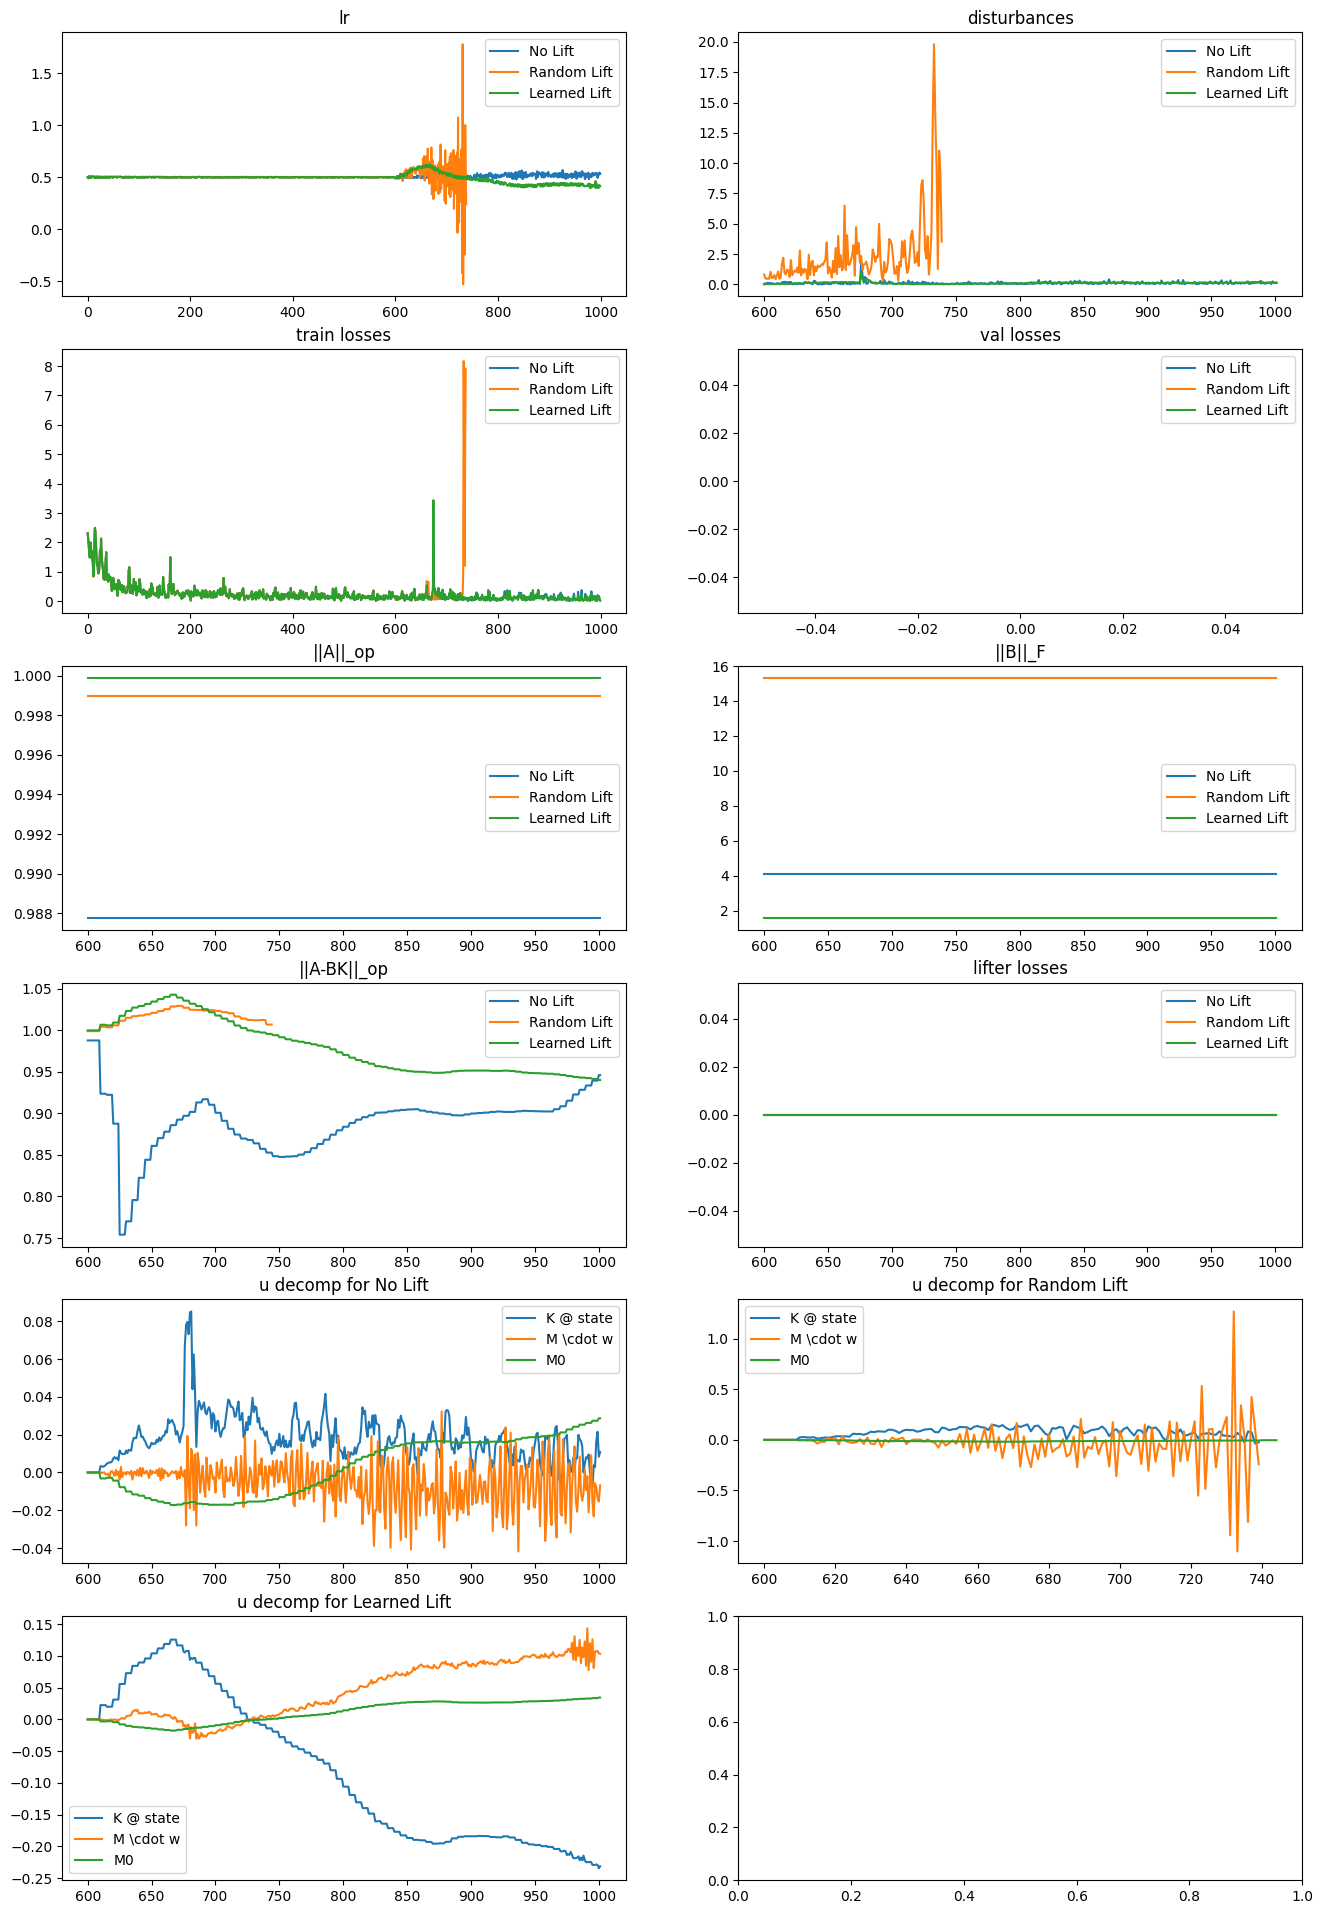

In [9]:
SEED = None
du = 1  # control dim
h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 10  # dimension to lift to

T = 1000
T0 = 600
reset_every = None

initial_lr = 0.5
M_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
M0_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
K_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))

sysid_method = 'regression'
sysid_scale = 0.01

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 3,
    'buffer_maxlen': 200,
    'batch_size': 10,
    'seed': SEED
}

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (M_UPDATE_RESCALER, M0_UPDATE_RESCALER, K_UPDATE_RESCALER),
    'T0': T0,
#     'bounds': (-initial_lr, 2 * initial_lr),
    'initial_u': jnp.zeros(du),
    'step_every': 5,
    'decay_scales': False,
    'use_sigmoid': True,
    'K_every': None,
    'seed': SEED
}

def apply_control(control, system): 
    system.opt.param_groups[0]['lr'] = initial_lr + control.item()
    pass

# get controllers
ll = LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args)
controllers = {
    'No Lift': LiftedBPC(lifter=NoLift(hh, du, SEED), 
                         sysid=SysID(sysid_method, du, hh, sysid_scale), 
                         **lifted_bpc_args),
    'Random Lift': LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], SEED), 
                             sysid=SysID(sysid_method, du, lift_dim, sysid_scale, SEED), 
                             **lifted_bpc_args),
    'Learned Lift': LiftedBPC(lifter=ll, 
                              sysid=ll, 
                              **lifted_bpc_args)
}

# run trials and plot
all_system_stats, all_controller_stats = {}, {}
for key, controller in controllers.items():
    print(key)
#     sys = LinearRegression(make_optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=initial_lr),
#                           apply_control = apply_control,
#                           dataset = 'generated',
#                           eval_every = 1,
#                           seed = SEED)
    sys = MNIST(make_optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=initial_lr),
                          apply_control = apply_control,
                          batch_size = 64,
                          seed = SEED)
    ss, cs = run_trial(controller, sys, T, reset_every=reset_every, reset_seed=SEED, wordy=True)
    if ss is None: continue
    all_system_stats[key] = ss
    all_controller_stats[key] = cs
    print()

plot_nn_stats(all_system_stats, all_controller_stats);